# Simple inverse problem

Almost according to the mixture density network paper.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import torch
from torch.utils.data import TensorDataset

from ada import f, get_dataset, MixtureDensityNetwork, Network, numpy2torch, pit, transform

## Train, valid and test data

In [2]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("inverse", 50, False)
x_train, y_train = trainset.tensors
x_valid, y_valid = validset.tensors
x_train, x_valid = map(X_scaler.inverse_transform, (x_train, x_valid))
y_train, y_valid = map(y_scaler.inverse_transform, (y_train, y_valid))
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((900, 1), (900, 1), (100, 1), (100, 1))

In [3]:
N_TEST = 100
y_test = torch.linspace(0.0, 1.0, steps=N_TEST).unsqueeze(-1)
x_test = f(y_test)
testset = TensorDataset(
    numpy2torch(X_scaler.transform(x_test)), numpy2torch(y_scaler.transform(y_test)))
x_test.shape, y_test.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

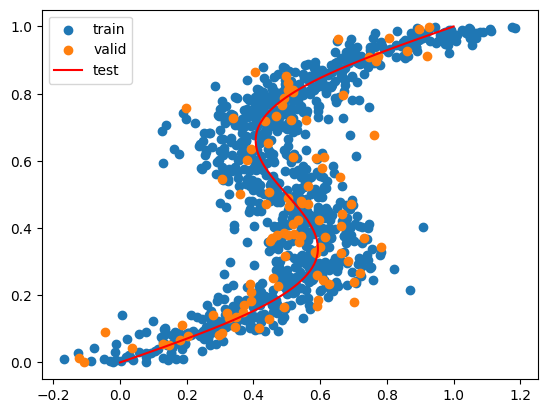

In [4]:
_, ax = plt.subplots()
ax.scatter(x_train, y_train, label="train")
ax.scatter(x_valid, y_valid, label="valid")
ax.plot(x_test, y_test, color="r", label="test")
ax.legend()

## NLL

In [5]:
hyperparams = {"neurons": 8}
hyperparams["loss"] = "nll"
model_nll = Network(x_train.shape[1], hyperparams)
model_nll.load("nll-1-2010")
mean_nll, var_nll = model_nll.predict(testset)
mean_nll, var_nll = transform(mean_nll, var_nll, y_scaler)
mean_nll.shape, var_nll.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

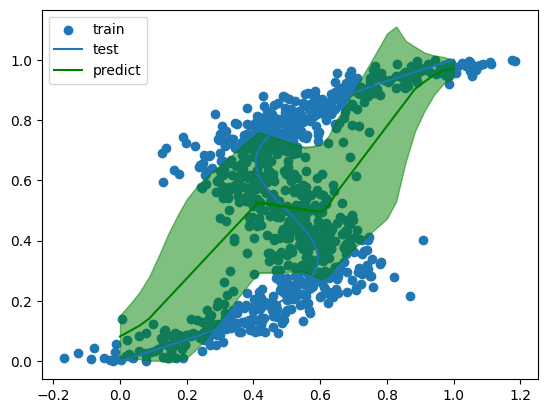

In [6]:
def plot_prediction(ax, x, mean, var):
    x, mean, var = map(torch.squeeze, (x, mean, var))
    std = var.sqrt()
    ax.plot(x, mean, color="green", label="predict")
    ax.fill_between(x, (mean - std), (mean + std), alpha=0.5, color="green")
    return ax

_, ax = plt.subplots()
ax.scatter(x_train, y_train, label="train")
ax.plot(x_test, y_test, label="test")
plot_prediction(ax, x_test, mean_nll, var_nll)
ax.legend()

## CRPS

In [7]:
hyperparams["loss"] = "crps"
model_crps = Network(x_train.shape[1], hyperparams)
model_crps.load("crps-1-4442")
mean_crps, var_crps = model_crps.predict(testset)
mean_crps, var_crps = transform(mean_crps, var_crps, y_scaler)

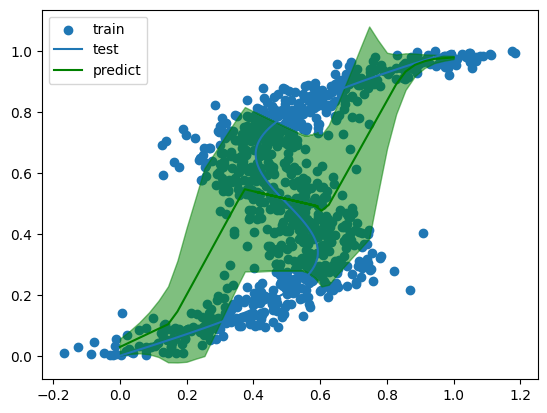

In [8]:
_, ax = plt.subplots()
ax.scatter(x_train, y_train, label="train")
ax.plot(x_test, y_test, label="test")
plot_prediction(ax, x_test, mean_crps, var_crps)
ax.legend()

## Mixture Density Network (MDN)

In [9]:
hyperparams["k"] = 3
hyperparams["neurons"] = 20
mdn_nll = MixtureDensityNetwork(x_train.shape[1], hyperparams)
mdn_nll.load("nll-1-3-2458")
coeffs_nll, means_nll, variances_nll = mdn_nll.predict(testset)
means_nll, variances_nll = transform(means_nll, variances_nll, y_scaler)
coeffs_nll.shape, means_nll.shape, variances_nll.shape

(torch.Size([100, 3]), torch.Size([100, 3]), torch.Size([100, 3]))

In [10]:
gmms = []
for i in range(coeffs_nll.shape[0]):
    gmm = GaussianMixture(n_components=hyperparams["k"], covariance_type="spherical")
    gmm.weights_ = coeffs_nll[i].numpy()
    gmm.means_ = means_nll[i].unsqueeze(-1).numpy()
    gmm.covariances_ = variances_nll[i].numpy()
    gmms.append(gmm)

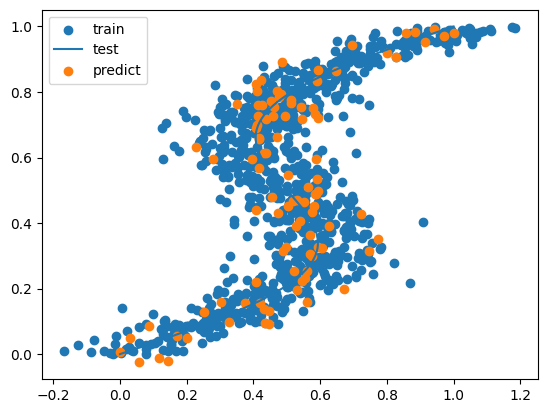

In [11]:
_, ax = plt.subplots()
ax.scatter(x_train, y_train, label="train")
ax.plot(x_test, y_test, label="test")
ax.scatter(x_test, [gmm.sample()[0][0, 0] for gmm in gmms], label="predict")
ax.legend()